<a href="https://colab.research.google.com/github/windopper/NLPDeepLearningPractice/blob/main/ConvolutionNerualNetwork/intent_classification_using_Pre_trained_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전 훈련된 워드 임베딩을 이용한 의도 분류

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

In [3]:
train_data

,intent,label
0,add another song to the cita rom ntica playlist,AddToPlaylist
1,add clem burke in my playlist pre party r b jams,AddToPlaylist
2,add live from aragon ballroom to trapeo,AddToPlaylist
3,add unite and win to my night out,AddToPlaylist
4,add track to my digster future hits,AddToPlaylist
...,...,...
11779,can a i get the movie schedule for sympathy fo...,SearchScreeningEvent
11780,find movie schedules for animated movies aroun...,SearchScreeningEvent
11781,what time is bordertown trail showing,SearchScreeningEvent
11782,in the neighbourhood find movies with movie times,SearchScreeningEvent


In [4]:
test_data

,intent,label
0,i 'd like to have this track onto my classical...,AddToPlaylist
1,add the album to my flow espa ol playlist,AddToPlaylist
2,add digging now to my young at heart playlist,AddToPlaylist
3,add this song by too poetic to my piano ballad...,AddToPlaylist
4,add this album to old school death metal,AddToPlaylist
...,...,...
595,is any cinema playing the spirit of youth,SearchScreeningEvent
596,what are the movie times for animated movies i...,SearchScreeningEvent
597,what 's the movie schedule at great escape the...,SearchScreeningEvent
598,show the times for cheers for miss bishop at d...,SearchScreeningEvent


In [5]:
intent_train = train_data.intent.tolist()
label_train = train_data.label.tolist()
intent_test = test_data.intent.tolist()
label_test = test_data.label.tolist()

print('훈련용 문장의 수 : ', len(intent_train))
print('훈련용 라벨의 수 : ', len(label_train))
print('테스트용 문장의 수 : ', len(intent_test))
print('테스트용 라벨의 수 :', len(label_test))

훈련용 문장의 수 :  11784
훈련용 라벨의 수 :  11784
테스트용 문장의 수 :  600
테스트용 라벨의 수 : 600


In [6]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']


In [7]:
print(intent_train[2000:2005])
print(label_train[2000:2005])

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian', 'book a table in belhaven for a party of seven at the great house at sonning', 'i want to book a restaurant near wyoming for 5 people', 'get me a table at eighth step coffee house in germania for 7']
['BookRestaurant', 'BookRestaurant', 'BookRestaurant', 'BookRestaurant', 'BookRestaurant']


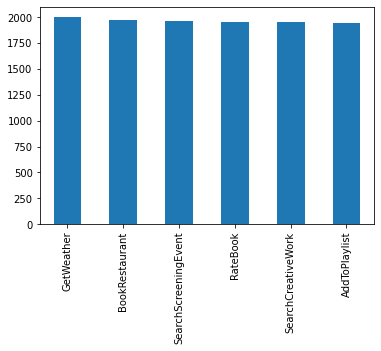

In [8]:
train_data['label'].value_counts().plot(kind='bar')

훈련 데이터에서 6개의 카테고리 ( 각각 AddToPlaylist, BookRestaurant, GetWeather , RateBook , SearchCreativeWork, SearchScreeningEvent)가 존재하는데 이를 정수로 인코딩 해야한다.

사이킷런의 preprocessing.LabelEncoder()가 유용하므로 이걸 사용하자

In [9]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train)
label_test = idx_encode.transform(label_test)

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :', label_idx)

레이블과 정수의 맵핑 관계 : {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


문장 토큰화

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5]

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [11]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 9870


패딩하기

문장의 최대 길이 :  35
문장의 평균 길이 :  9.364392396469789


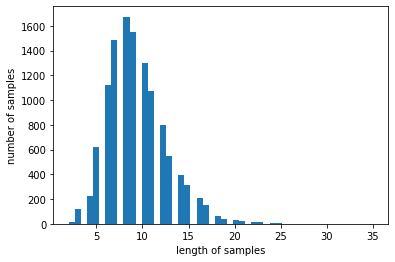

In [14]:
print('문장의 최대 길이 : ', max(len(l) for l in sequences))
print('문장의 평균 길이 : ', sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
max_len = 35

intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('훈련 데이터의 크기(shape):', intent_train.shape)
print('훈련 데이터 레이블의 크기(shape):', label_train.shape)

훈련 데이터의 크기(shape): (11784, 35)
훈련 데이터 레이블의 크기(shape): (11784, 6)


데이터 랜덤 섞기

In [17]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 : ', indices)

랜덤 시퀀스 :  [10622  7196  9267 ...  7837  6109 11338]


In [18]:
intent_train = intent_train[indices]
label_train = label_train[indices]

In [19]:
n_of_val = int(0.1 * intent_train.shape[0])
print('검증 데이터의 개수 :', n_of_val)

검증 데이터의 개수 : 1178


In [36]:
x_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
x_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
x_test = intent_test
y_test = label_test

In [38]:
print('훈련 데이터의 크기(shape):', x_train.shape)
print('검증 데이터의 크기(shape):', x_val.shape)
print('훈련 데이터 레이블의 크기(shape):', y_train.shape)
print('검증 데이터 레이블의 크기(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(x_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 크기(shape): (10606, 6)
검증 데이터 레이블의 크기(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


# 사전 훈련된 워드 임베딩 사용하기

스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩 사용

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-02-03 13:09:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-03 13:09:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-03 13:09:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [28]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :', np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


In [29]:
for word, i in word_index.items():
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

1D CNN을 이용한 모델 설계

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPool1D, Dense, Input, Flatten, Concatenate

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5
model_input = Input(shape=(max_len, ))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
  conv = Conv1D(
      filters=num_filters,
      kernel_size=size,
      padding='valid',
      activation='relu',
      strides=1
  )(output)

  conv = GlobalMaxPool1D()(conv)
  conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 35, 100)      987000      ['input_5[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 34, 512)      102912      ['embedding_3[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 33, 512)      154112      ['embedding_3[0][0]']            
                                                                                            

In [40]:
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
166/166 [==============================] - 5s 22ms/step - loss: 0.2044 - acc: 0.9355 - val_loss: 0.0558 - val_acc: 0.9839
Epoch 2/10
166/166 [==============================] - 3s 16ms/step - loss: 0.0503 - acc: 0.9853 - val_loss: 0.0337 - val_acc: 0.9890
Epoch 3/10
166/166 [==============================] - 3s 16ms/step - loss: 0.0282 - acc: 0.9911 - val_loss: 0.0285 - val_acc: 0.9898
Epoch 4/10
166/166 [==============================] - 3s 15ms/step - loss: 0.0234 - acc: 0.9931 - val_loss: 0.0268 - val_acc: 0.9907
Epoch 5/10
166/166 [==============================] - 3s 16ms/step - loss: 0.0166 - acc: 0.9953 - val_loss: 0.0250 - val_acc: 0.9915
Epoch 6/10
166/166 [==============================] - 3s 21ms/step - loss: 0.0102 - acc: 0.9975 - val_loss: 0.0301 - val_acc: 0.9890
Epoch 7/10
166/166 [==============================] - 3s 16ms/step - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0287 - val_acc: 0.9890
Epoch 8/10
166/166 [==============================] - 3s 16ms/step - 

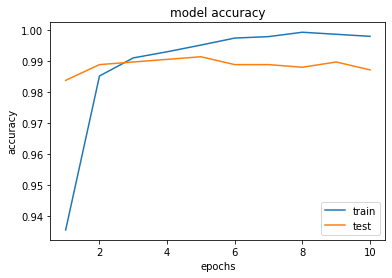

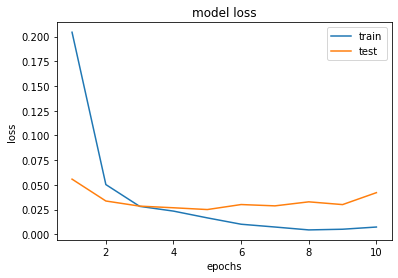

In [43]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [44]:
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=max_len)


In [45]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.argmax(axis=-1)

In [47]:
print('정확도 (Accuracy) : ', sum(y_predicted == y_test) / len(y_test))

정확도 (Accuracy) :  0.9866666666666667
